In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23
2016-08-23 00:00:00


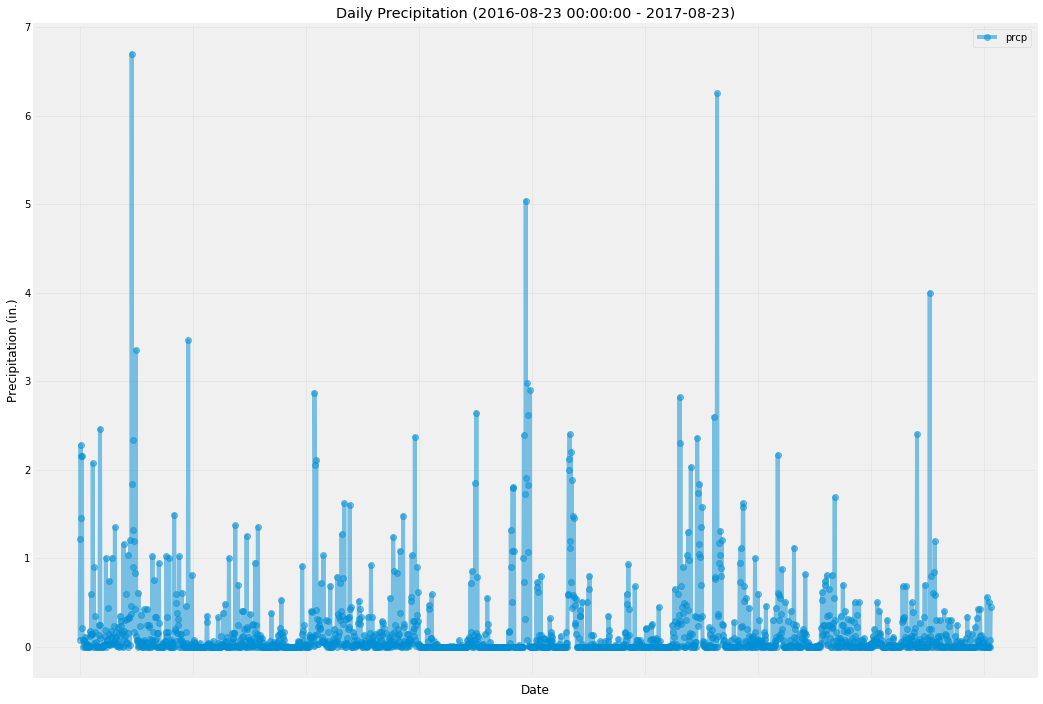

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

print(date[0])

year_ago = dt.datetime.strptime(date[0], "%Y-%m-%d") - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp).dropna()
df.set_index('date', inplace=True)
df.index.name = None

# Sort the dataframe by date
ndf = df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ndf.plot(figsize=(16,12), alpha=.5, marker='o')
plt.title(f'Daily Precipitation ({year_ago} - {date[0]})')
plt.ylabel('Precipitation (in.)')
plt.xlabel('Date')
plt.grid(alpha=.25)
plt.savefig("Output/Daily Precipitation - Last 12 Months.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
ndf.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station = count[0][0]
print(f'Most active station is {station} with {count[0][1]} records.')
session.query(func.min(Measurement.tobs), 
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).\
    filter(Measurement.station == station).all()

Most active station is USC00519281 with 2772 records.


[(54.0, 85.0, 71.66378066378067)]

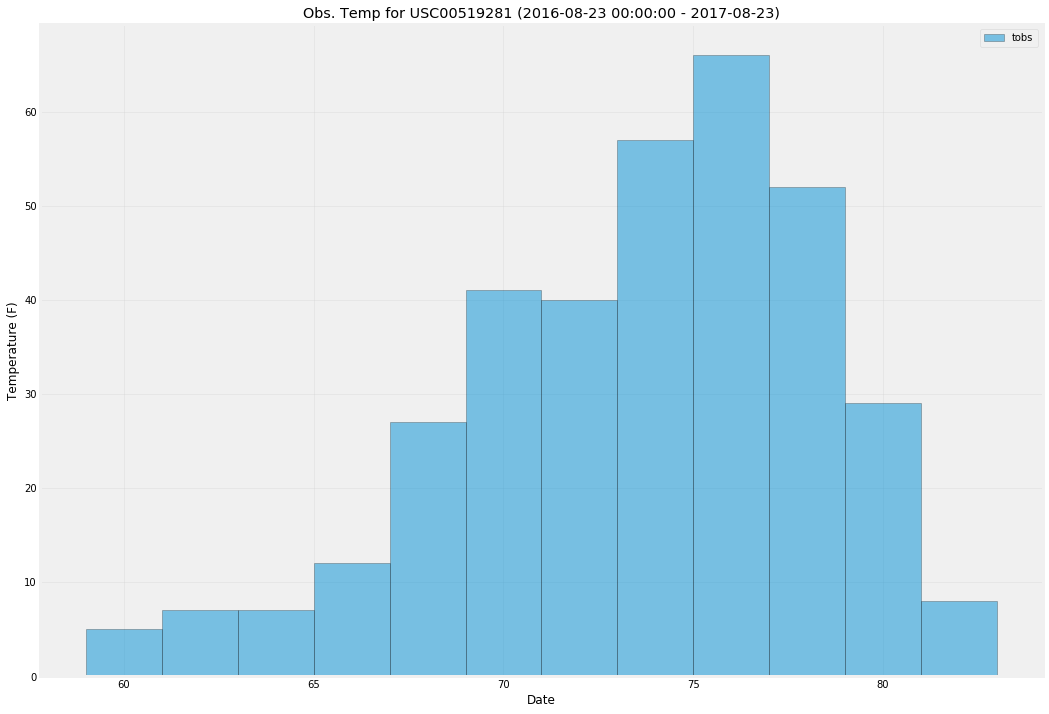

In [71]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == station).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(tobs).dropna()
df.set_index('date', inplace=True)
df.index.name = None

# Sort the dataframe by date
ndf = df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
ndf.plot.hist(figsize=(16,12), bins=12, alpha=.5, edgecolor='black')
plt.title(f'Obs. Temp for {station} ({year_ago} - {date[0]})')
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.grid(alpha=.25)
plt.savefig("Output/Obs Temp - Last 12 Months.png")
plt.show()

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [62]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start = '2016-11-01'
end = '2016-11-15'
print(calc_temps(start, end))

[(63.0, 74.37894736842105, 79.0)]


C:\Users\WOODS4\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


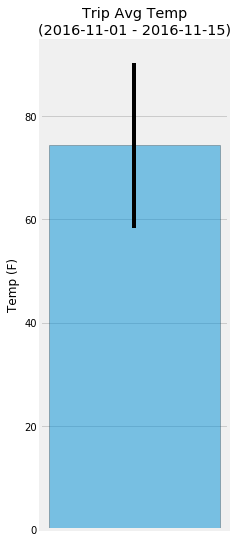

In [74]:
avg = calc_temps(start, end)[0][1]
ptp = calc_temps(start, end)[0][2] - calc_temps(start, end)[0][0]
plt.figure(figsize=(3,9))
plt.bar(x=0, height=avg, yerr = ptp, alpha=0.5, edgecolor='black')
plt.title(f'Trip Avg Temp\n({start} - {end})')
plt.ylabel('Temp (F)')
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)
plt.savefig("Output/Trip Avg Temp.png")
plt.show()

In [66]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

year_ago_start = dt.datetime.strptime(start, "%Y-%m-%d") - dt.timedelta(days=366)
year_ago_end = dt.datetime.strptime(end, "%Y-%m-%d") - dt.timedelta(days=366)

print(year_ago_start)
print(year_ago_end)

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= year_ago_start).filter(Measurement.date <= year_ago_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

2015-11-01 00:00:00
2015-11-15 00:00:00


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  8.54),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.94),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.87),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.8600000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.81),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.5),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.32),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


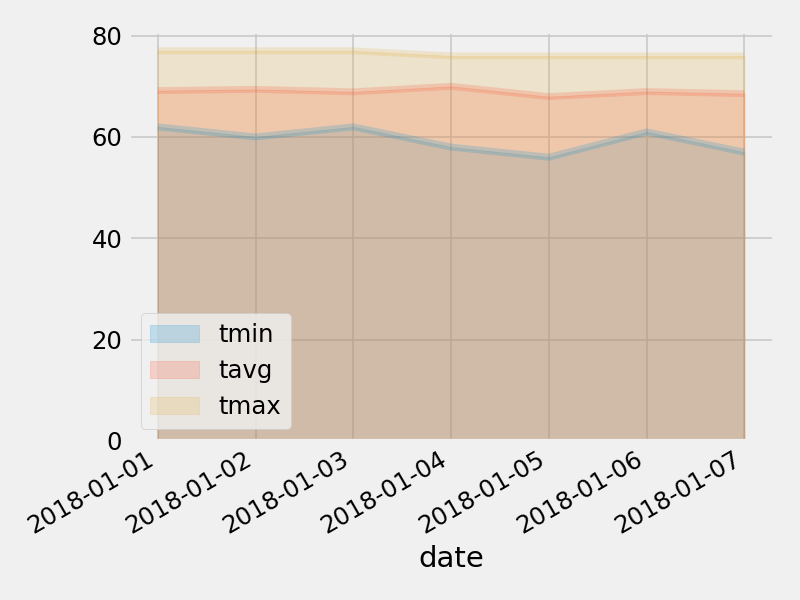

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
